In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import xarray as xr

print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.4


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)

- floor==0 -> IsBasement ==True
- floor==1 -> IsBasement ==False

In [6]:
data[["county", "log_radon", "floor"]].head()

county  log_radon  floor
0  AITKIN   0.832909    1.0
1  AITKIN   0.832909    0.0
2  AITKIN   1.098612    0.0
3  AITKIN   0.095310    0.0
4   ANOKA   1.163151    0.0

In [7]:
data["county"].unique()

array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR',
       'LINCOLN', 'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD',
       'MEEKER', 'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET',
       'NOBLES', 'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE',
       'PIPESTONE', 'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE',
       'RICE', 'ROCK', 'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY',
       'ST LOUIS', 'STEARNS', 'STEELE', 'STEVENS', 'SWIFT', 'TODD',
       'TRAVERSE', 'WABASHA', 'WADENA', 'WASECA', 'WASHINGTON',
       'WATONWAN', '

<AxesSubplot:title={'center':'log_radon'}, xlabel='county'>

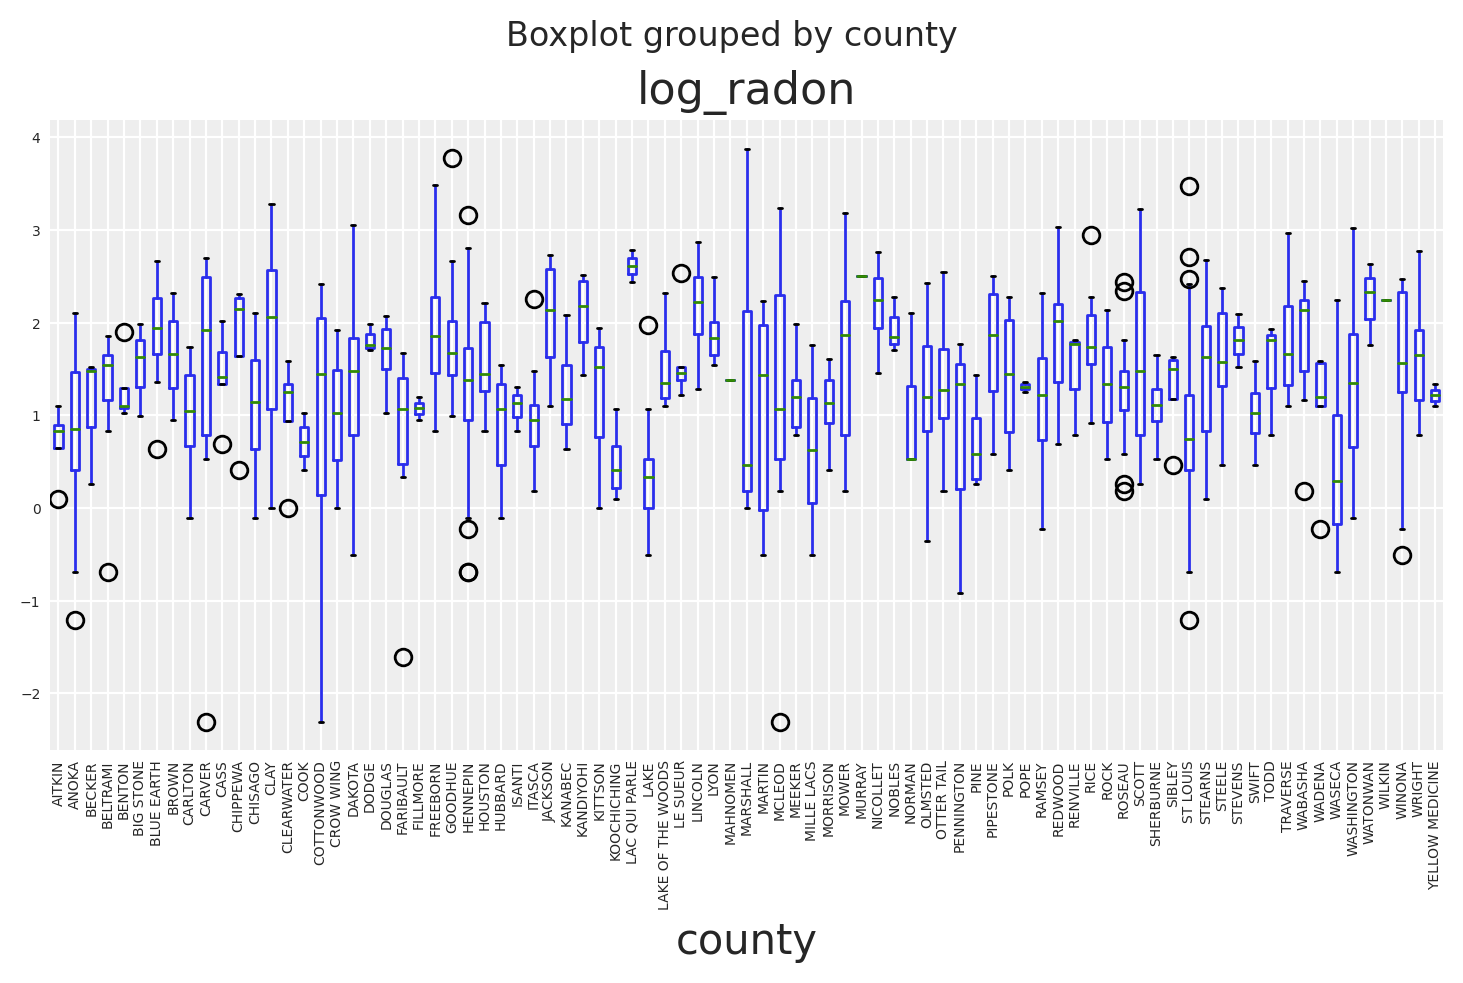

In [36]:
data.boxplot("log_radon",by="county", rot=90, fontsize=5)

In [9]:
data[["county", "log_radon", "floor"]].describe()

log_radon       floor
count  919.000000  919.000000
mean     1.264779    0.166485
std      0.819355    0.372719
min     -2.302585    0.000000
25%      0.693147    0.000000
50%      1.308333    0.000000
75%      1.808289    0.000000
max      3.877432    1.000000

In [47]:
data["county"].value_counts()

ST LOUIS           116
HENNEPIN           105
DAKOTA              63
ANOKA               52
WASHINGTON          46
                  ... 
MILLE LACS           2
YELLOW MEDICINE      2
MAHNOMEN             1
WILKIN               1
MURRAY               1
Name: county, Length: 85, dtype: int64

$$ radon_{i,c}=\alpha_c + \beta_c \times floor_{i,c} + \epsilon_c $$

$$\alpha_c = N(\mu_\alpha, \sigma^2_\alpha)$$
$$\beta_c = N(\mu_\beta, \sigma^2_\beta)$$

In [48]:
county_idxs, counties = pd.factorize(data.county)
print("county_idxs:",county_idxs)
print("counties:",counties)


county_idxs: [ 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  2  2  3  3  3  3  3  3  3  4  4  4  4  5  5
  5  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7  8  8  8  8  8
  8  8  8  8  8  9  9  9  9  9  9 10 10 10 10 10 11 11 11 11 12 12 12 12
 12 12 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 15 15 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 19 19 19 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21 22
 22 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25 25
 25 25 25 25 25 25 25 25 25 25 25 25 2

In [68]:
counties.get_loc("BECKER")


2

In [69]:
county_idxs, counties = pd.factorize(data.county)

coords = {
    "county": counties,
    "obs_id": np.arange(len(county_idxs)),
}
coords

{'county': Index(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
        'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
        'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
        'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
        'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
        'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
        'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
        'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
        'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
        'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
        'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
        'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
        'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADENA',
        'WASECA', 'WASHINGTO

In [50]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="county")
    # effect difference between basement and floor level
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal(
        "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, dims="obs_id"
    )

In [51]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


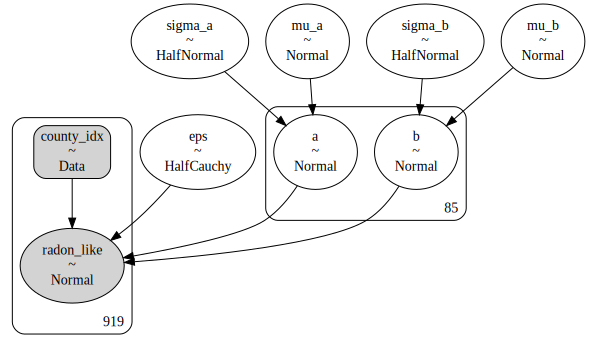

In [54]:
pm.model_to_graphviz(hierarchical_model)

/tmp/ipykernel_7262/3884850394.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  _ = pm.traceplot(hierarchical_trace)


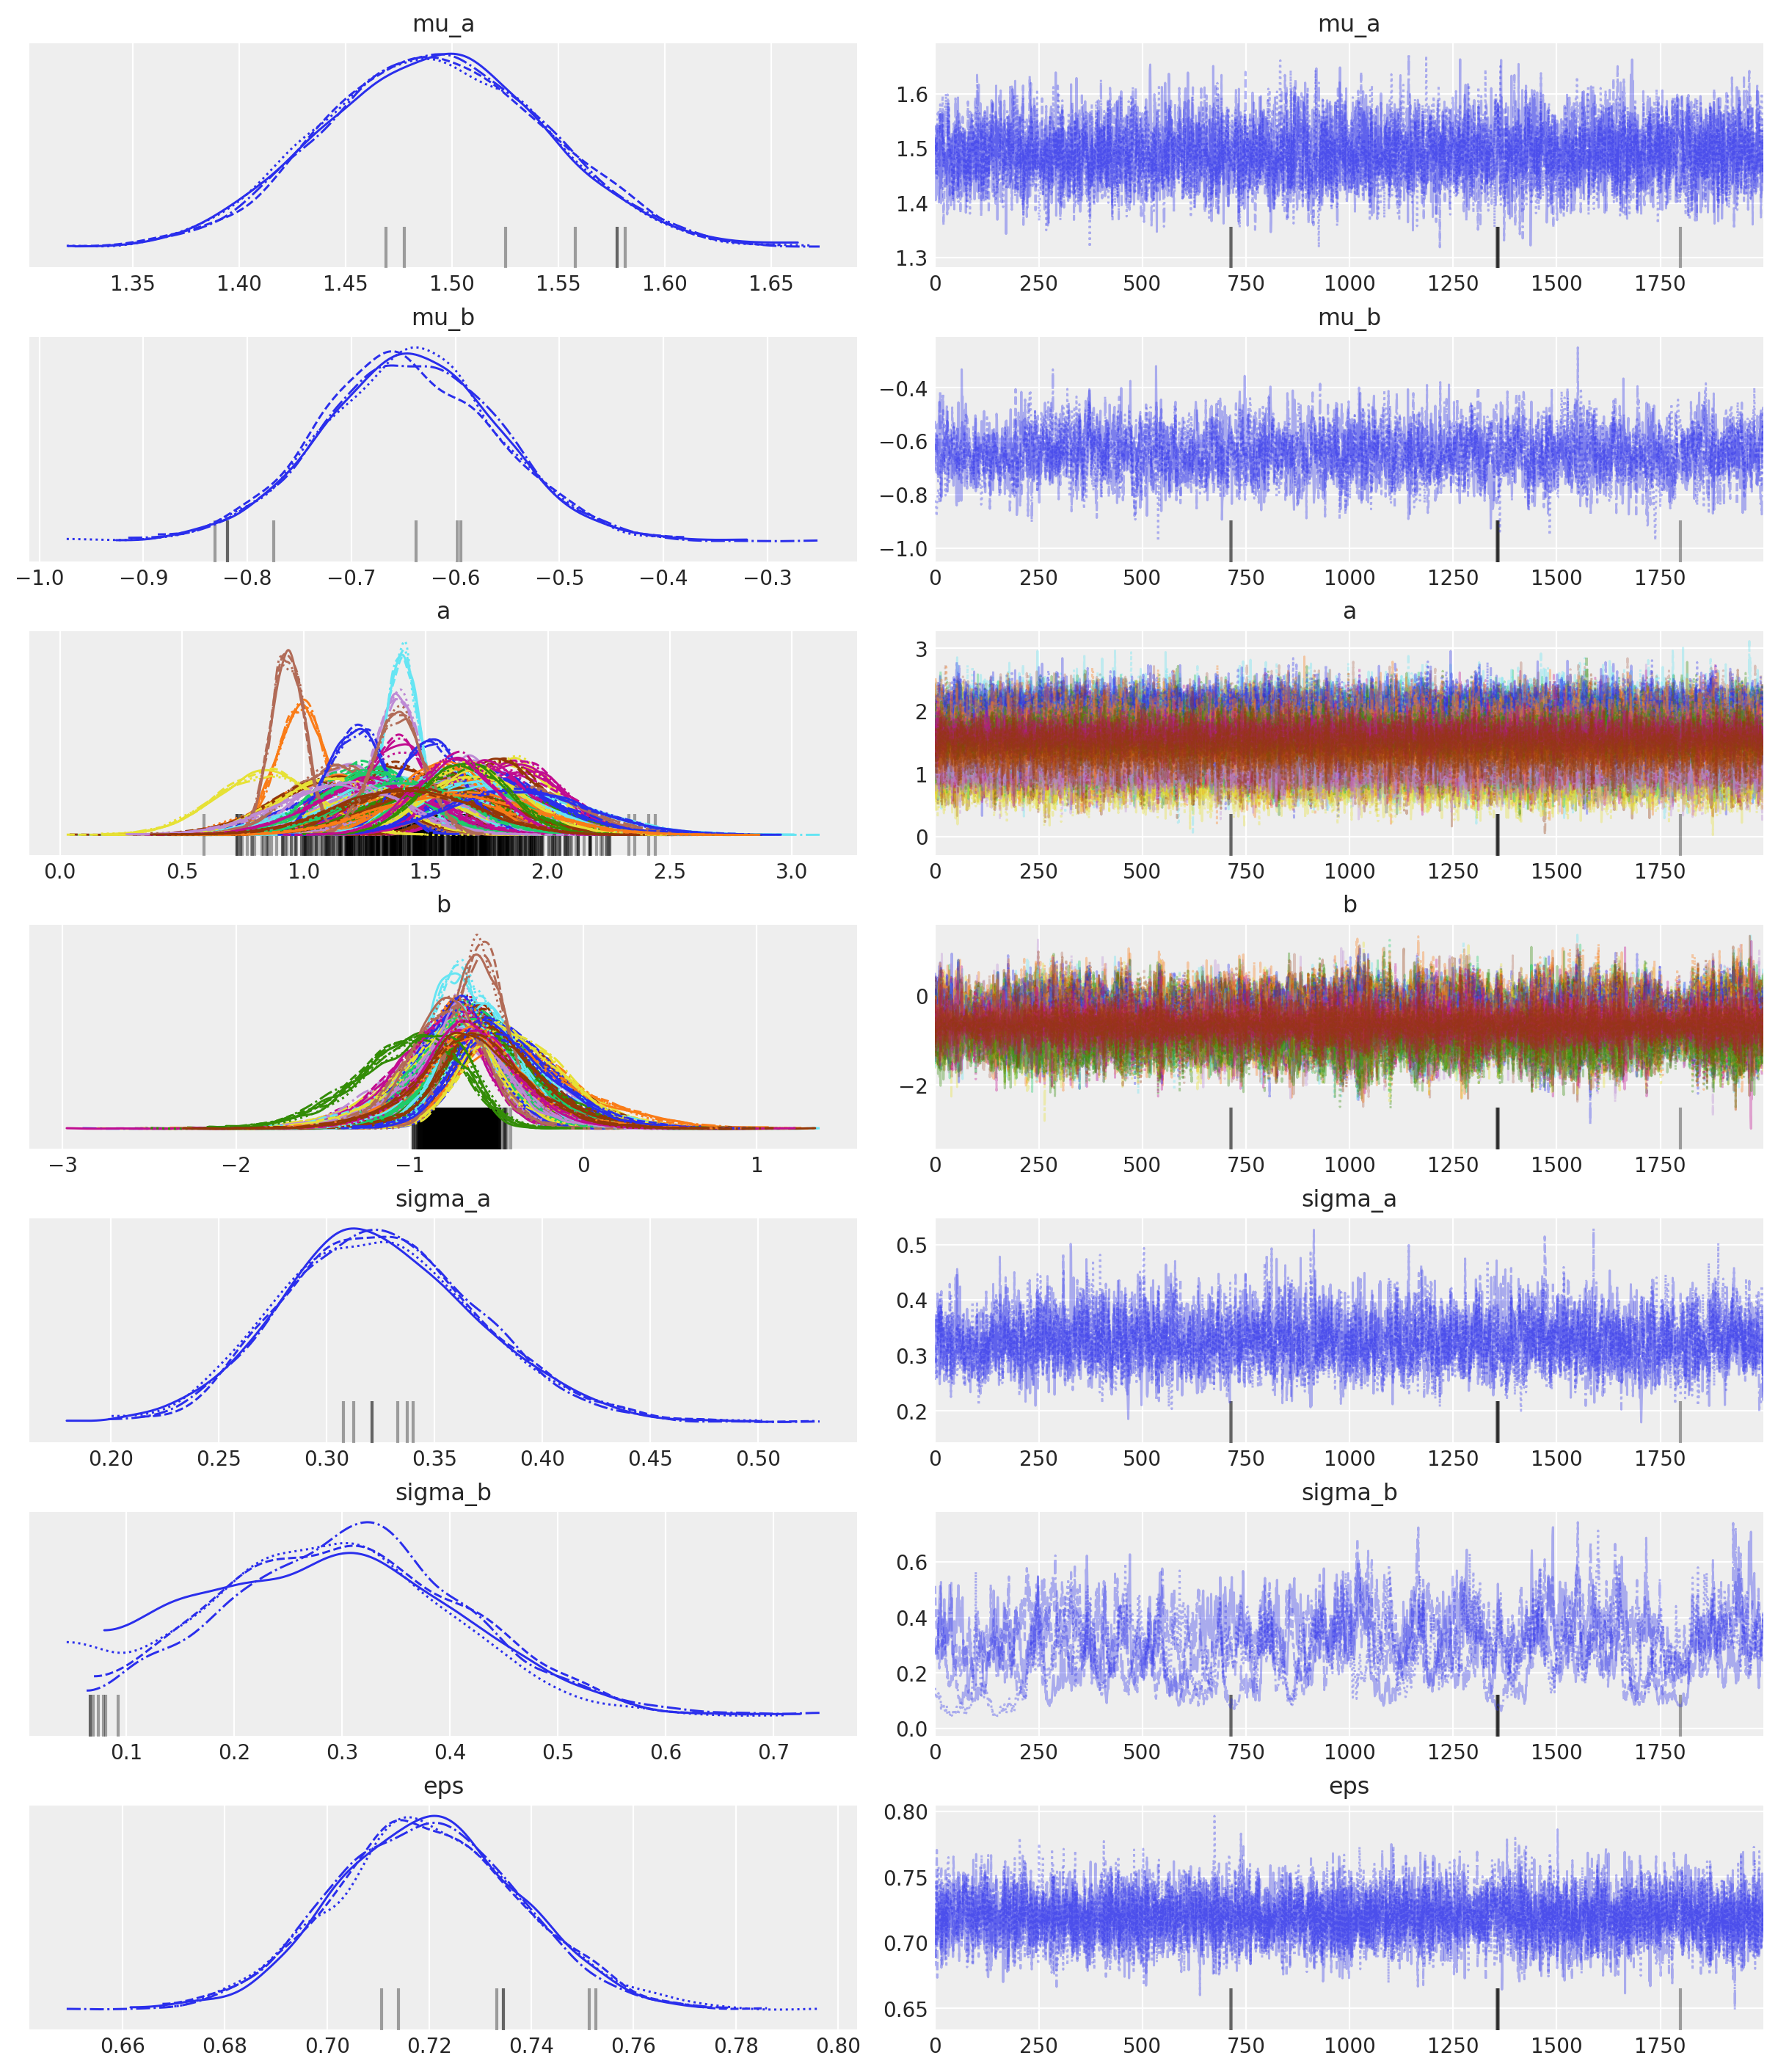

In [52]:
_ = pm.traceplot(hierarchical_trace)

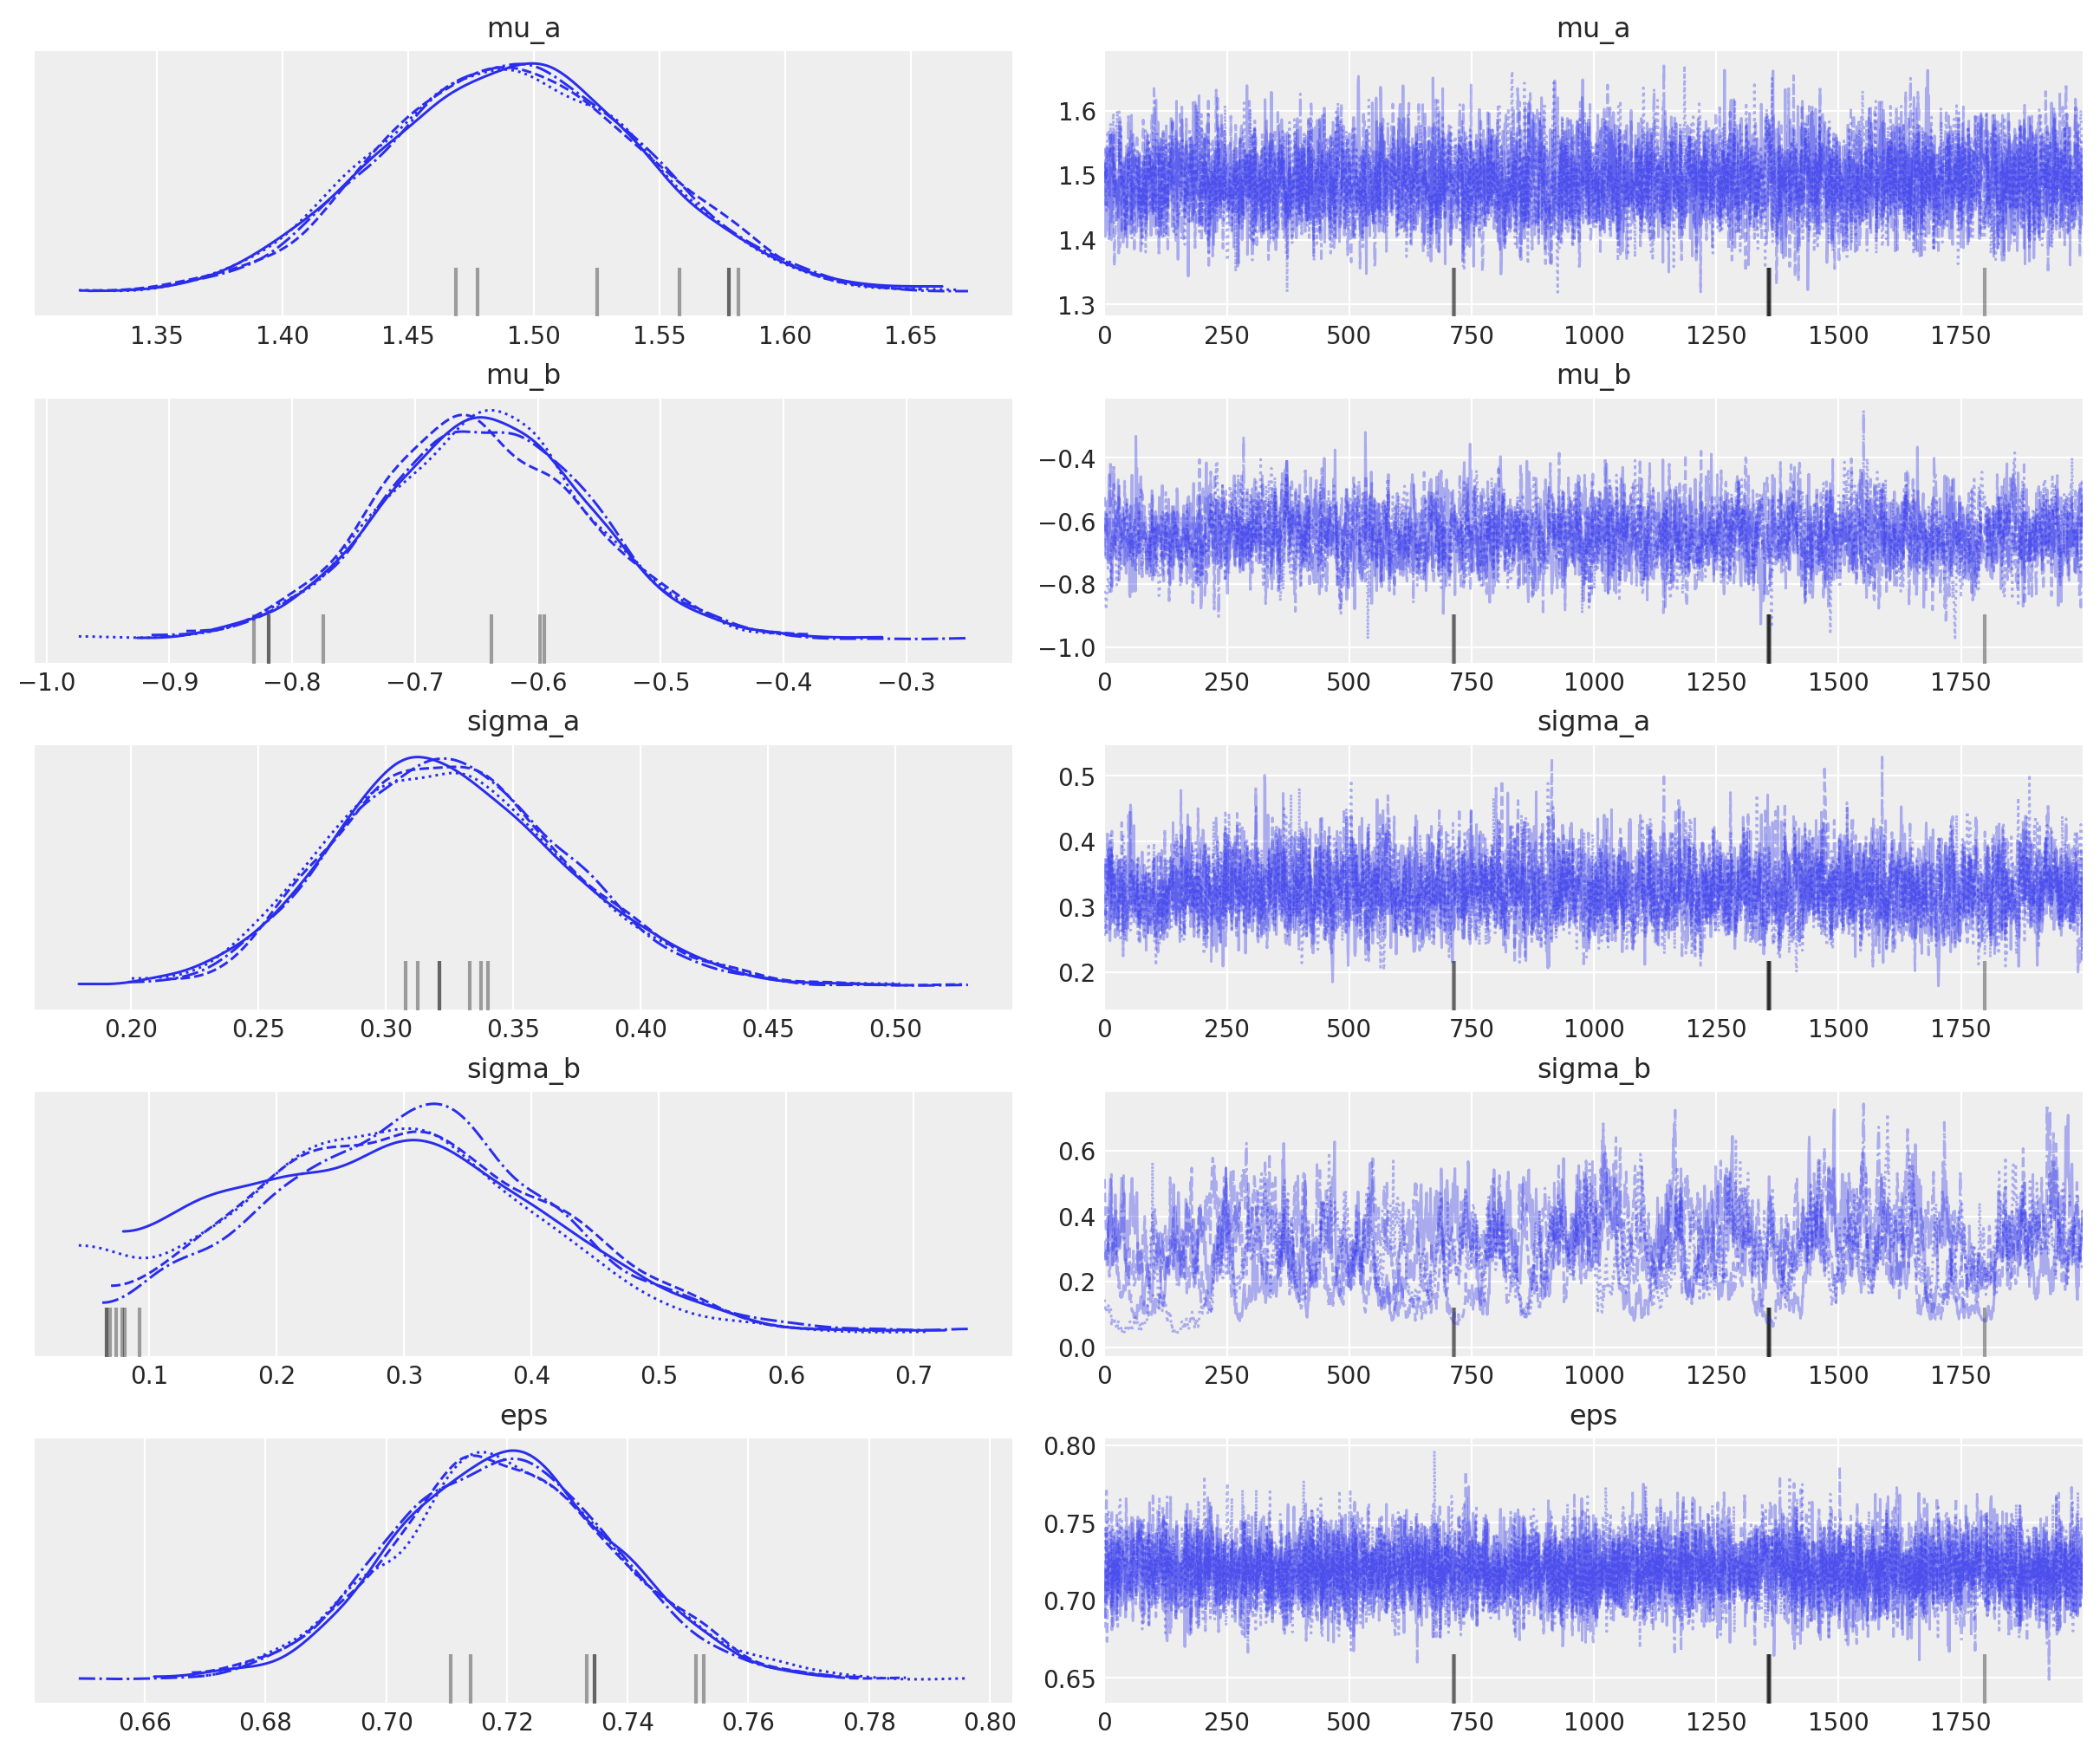

In [71]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

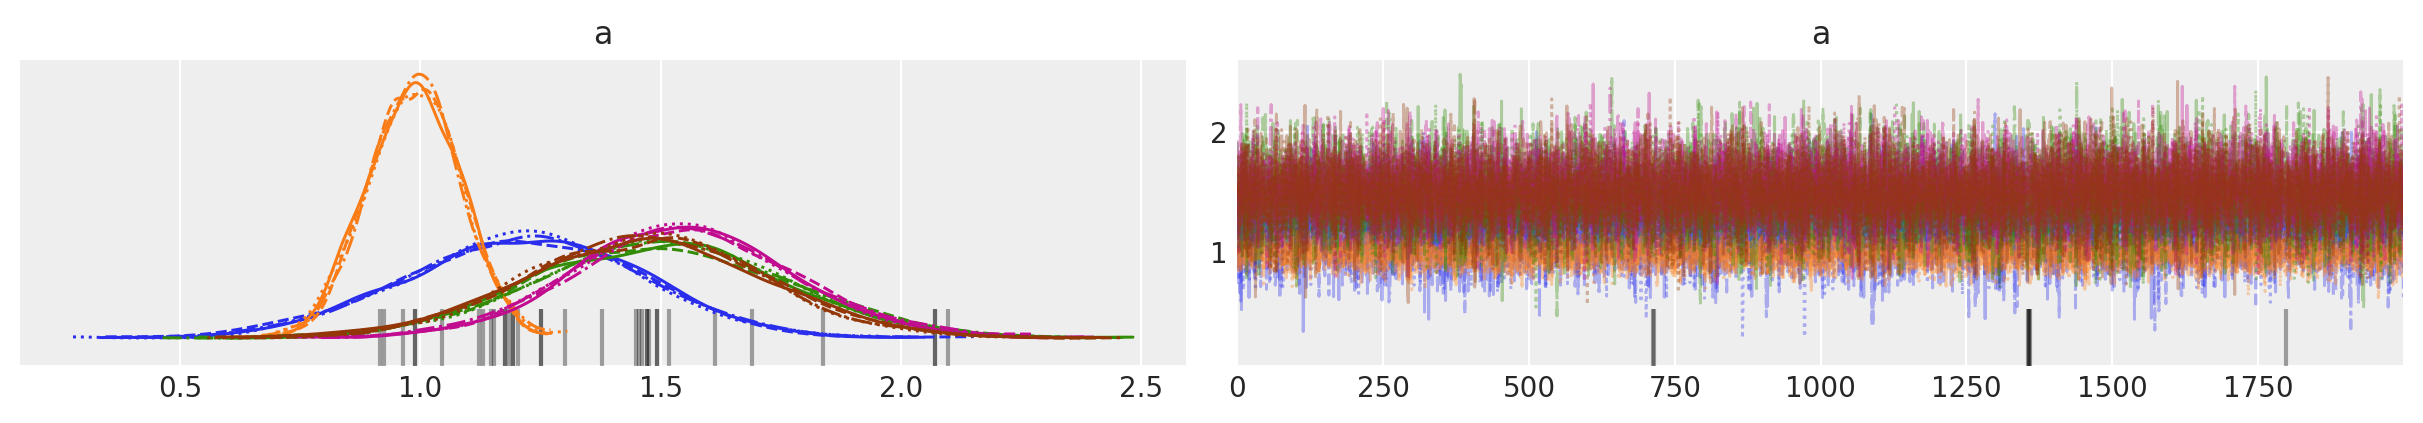

In [70]:
az.plot_trace(hierarchical_trace, var_names=["a"], coords={"county": counties[:5]})

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

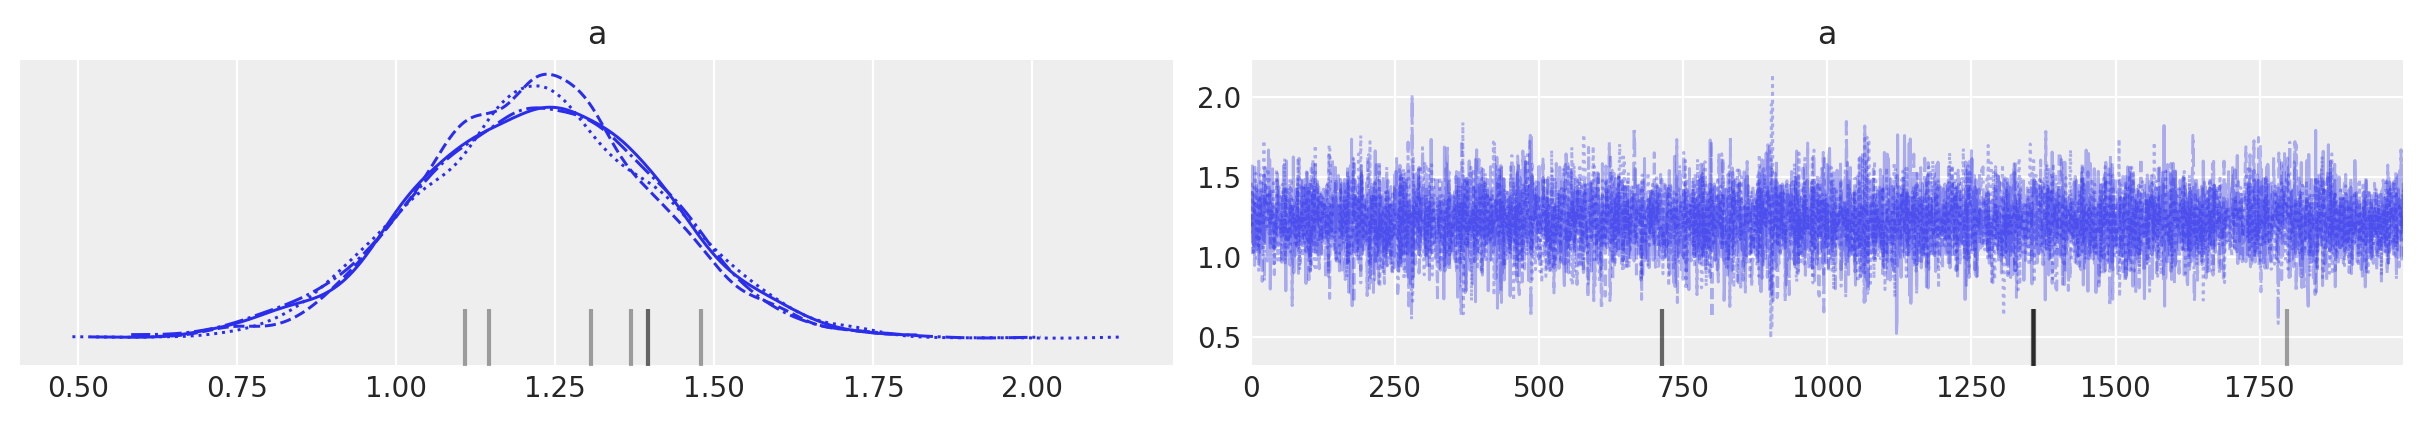

In [86]:

az.plot_trace(hierarchical_trace, var_names=["a"], coords={"county": counties[counties.get_loc("CROW WING")]})

In [89]:
selection = ["CASS", "CROW WING", "FREEBORN"]
xvals = xr.DataArray(np.linspace(-0.2, 1.2, num=85), dims=["x_plot"])

#unpooled_post = unpooled_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post = hierarchical_trace.posterior.stack(chain_draw=("chain", "draw"))
hier_post

<xarray.Dataset>
Dimensions:     (chain_draw: 8000, county: 85)
Coordinates:
  * county      (county) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Data variables:
    mu_a        (chain_draw) float64 1.505 1.405 1.409 ... 1.459 1.473 1.473
    mu_b        (chain_draw) float64 -0.7072 -0.5935 -0.6041 ... -0.5643 -0.5633
    a           (county, chain_draw) float64 1.574 0.8219 1.026 ... 1.476 1.428
    b           (county, chain_draw) float64 -0.6799 -0.4861 ... -0.2479 -0.5685
    sigma_a     (chain_draw) float64 0.3087 0.3725 0.2867 ... 0.2364 0.2418
    sigma_b     (chain_draw) float64 0.2685 0.284 0.2888 ... 0.2505 0.2437
    eps         (chain_draw) float64 0.7241 0.7073 0.7018 ... 0.7282 0.7362
Attributes:
    created_at:                 2021-12-14T12:58:01.011039
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.4
    sampling_time:              21.691440105438232
    tuning_steps:               2000

In [94]:
hier_est = (hier_post["a"] + hier_post["b"] * xvals).transpose("x_plot", ...)
hier_est

<xarray.DataArray (x_plot: 85, county: 85, chain_draw: 8000)>
array([[[ 1.70996286,  0.91915972,  1.12071326, ...,  1.34115799,
          1.43392332,  1.33574102],
        [ 1.18623228,  1.14381706,  1.02153958, ...,  1.22084855,
          1.20339206,  1.13293291],
        [ 2.0627428 ,  1.20727589,  1.53532576, ...,  1.40279531,
          1.61340696,  1.51770053],
        ...,
        [ 1.98454048,  1.94882786,  1.74833652, ...,  1.66156193,
          1.70048294,  1.87882776],
        [ 1.35645693,  2.0247275 ,  1.57981073, ...,  1.83986314,
          1.92718799,  1.42712856],
        [ 1.53249266,  1.6046862 ,  1.52594275, ...,  1.43521185,
          1.525378  ,  1.5421866 ]],

       [[ 1.69863078,  0.91105793,  1.11282471, ...,  1.32984903,
          1.43146455,  1.31835362],
        [ 1.16923644,  1.13315707,  1.01052152, ...,  1.21022654,
          1.18867705,  1.12371104],
        [ 2.04976325,  1.19374732,  1.52812026, ...,  1.39521204,
          1.60525418,  1.50590637],
...
        [ 0.42079702,  0.80941197,  0.58648479, ...,  0.56249336,
          0.44823029,  0.57689778],
        [ 1.01783207,  1.05503519,  0.92706781, ...,  0.68116862,
          1.26232872,  0.96602843],
        [-0.06694757,  0.87200552,  0.53048874, ...,  0.22228765,
          1.18243417,  0.75574262]],

       [[ 0.75806849,  0.23860935,  0.45807505, ...,  0.39120548,
          1.22738667, -0.12480124],
        [-0.24141839,  0.24837789,  0.09602251, ...,  0.32859964,
         -0.03266921,  0.35829524],
        [ 0.97246008,  0.07087646,  0.93006345, ...,  0.76580069,
          0.92857318,  0.52699128],
        ...,
        [ 0.40195674,  0.79568407,  0.57248658, ...,  0.54925157,
          0.4331429 ,  0.56121187],
        [ 1.01375225,  1.04335215,  0.91920344, ...,  0.66720845,
          1.25431837,  0.960473  ],
        [-0.08621794,  0.86317804,  0.51849532, ...,  0.2076741 ,
          1.17830231,  0.74626739]]])
Coordinates:
  * county      (county) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * chain_draw  (chain_draw) MultiIndex
  - chain       (chain_draw) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3
  - draw        (chain_draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: x_plot

In [96]:
rng = np.random.default_rng(0)
rng

Generator(PCG64) at 0x7F1BE0ED2E40

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()

random_subset = rng.permutation(np.arange(len(hier_est["chain_draw"])))[:200]

for i, c in enumerate(selection):
    ### unpooled model ###
    unpooled_c = unpooled_est.sel(county=c)
    unpooled_means = unpooled_post.sel(county=c).mean()
    # plot all samples from unpooled model
    axis[i].plot(xvals, unpooled_c.isel(chain_draw=random_subset), color="C0", alpha=0.1)
    # plot mean from unpooled model
    axis[i].plot(
        xvals,
        unpooled_means["a"] + unpooled_means["b"] * xvals,
        color="C0",
        alpha=1,
        lw=2.0,
        label="unpooled",
    )
    ### hierarchical model ##
    hier_c = hier_est.sel(county=c)
    hier_means = hier_post.sel(county=c).mean()
    # plot all samples
    axis[i].plot(xvals, hier_c.isel(chain_draw=random_subset), color="C1", alpha=0.1)
    # plot mean
    axis[i].plot(
        xvals,
        hier_means["a"] + hier_means["b"] * xvals,
        color="C1",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    # observed_data
    obs_data_c = observed_data.where(obs_county.isin(selection), drop=True)
    axis[i].scatter(
        obs_data_c["floor"] + rng.normal(scale=0.01, size=len(obs_data_c["floor"])),
        obs_data_c["y"],
        alpha=0.5,
        color="k",
        marker=".",
        s=80,
        zorder=3,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")